In [36]:
# mapping = {
#     0: 0.707+0.707j,
#     1: 0.707-0.707j,
#     2: -0.707+0.707j,
#     3: -0.707-0.707j
# }
# Cluster = 200

# from matplotlib import pyplot as plt
# Nr = 4


# def evaluateSincPulse(t):
#     if t == 0:
#         pulseValue = 1.0
#     else:
#         pulseValue = np.sin(np.pi * t) / (np.pi * t)
#     return pulseValue
# def symbol_clusterGen(Nr, Cluster, num_training_samples):
#     y = np.zeros(shape = (num_training_samples, Nr, Cluster), dtype = complex)
#     y_n = np.zeros(shape = (num_training_samples, Nr, Cluster), dtype = complex)
#     x = np.zeros(shape = (num_training_samples, Cluster, 1), dtype = complex)
#     x_map = np.zeros(shape = (num_training_samples, Cluster))
    
#     for sample_cnt in range (num_training_samples):
#         h = np.ones(shape = (Nr, 1), dtype=complex) # h is certain for each sample
#         signal = np.random.randint(low = 0, high = 4, size = (Cluster, 1))
#         x_map[sample_cnt] = signal.squeeze()
#         x[sample_cnt] = np.expand_dims(
#             np.array(
#                 [mapping[int(_s)] for _s in signal]
#             ),
#             1 
#         ) 

#         for i in range (Nr):
#             a = np.random.randn(1) + 1j * np.random.randn(1)
#             phase = np.random.uniform(0, np.pi)
#             delay = 1e-6 * np.random.randn()
#             h[i] = a * np.exp(1j * phase) * evaluateSincPulse(delay)
#             y[sample_cnt, i, :] = np.squeeze(h[i] * signal)
#             y_n[sample_cnt, i, :] = y[sample_cnt, i, :] + 0.01 * (np.random.randn(Cluster,) + 1j * np.random.randn(Cluster,))

#     return x_map, y, y_n

# training_samples = 4000 # 4000 channel states
# Nr = 4
# cluster = 200
# x, y, y_n = symbol_clusterGen(Nr, cluster, training_samples)


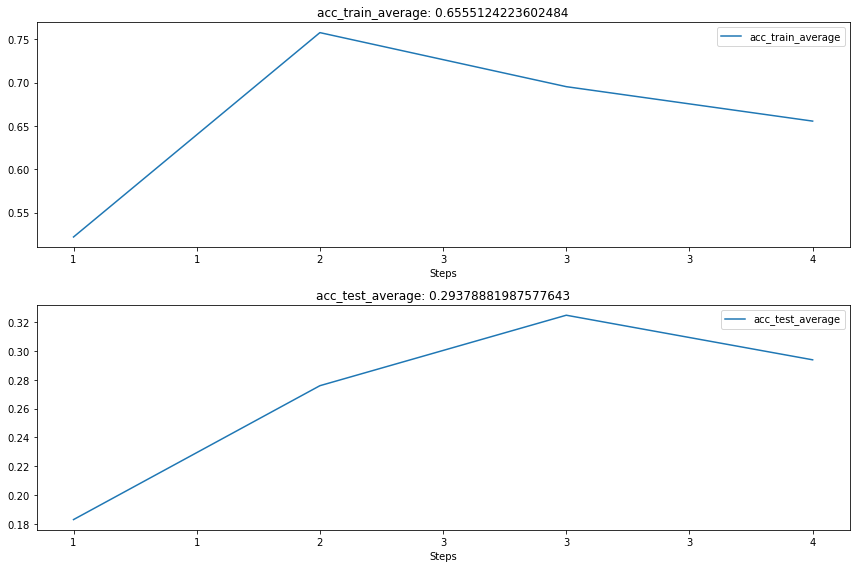

KeyboardInterrupt: 

In [37]:
import torch
import numpy as np
from data_processing import *
import scipy.io as spio
from torch.nn import functional as F


Nr = 4
carrier_num = 16
symbol_num = 200
channel_num = 4000

def cross_entropy(y_true,y_pred):
    C=0
    # one-hot encoding
    for col in range(y_true.shape[-1]):
        y_pred[col] = y_pred[col] if y_pred[col] < 1 else 0.99999
        y_pred[col] = y_pred[col] if y_pred[col] > 0 else 0.00001
        C+=y_true[col]*torch.log(y_pred[col])+(1-y_true[col])*torch.log(1-y_pred[col])
    return -C
_channel = {}
_tau = list()
_fdoppler = list()
_Txsteering = list()
_Rxsteering = list()
_x = list()
_y = list()
_y_norm = list()
h = list()

for i in range(1, channel_num+1):
    path = f'./test_data/ISAC_QPSK_OFDM_{i}.mat'
    data = spio.loadmat(path)
    _tau.append(
        data['ISAC_data']['channel'][0][0]['time_delay'][0][0][0]
    )
    _fdoppler.append(
        data['ISAC_data']['channel'][0][0]['f_doppler'][0][0][0]
    )
    _Txsteering.append(
        data['ISAC_data']['channel'][0][0]['Tx_steeringangle'][0][0][0]
    )
    _Rxsteering.append(
        data['ISAC_data']['channel'][0][0]['Rx_steeringangle'][0][0][0]
    )
    _x.append(
        data['ISAC_data']['x'][0][0]
    )
    _y.append(
        data['ISAC_data']['y'][0][0]
    )
    _y_norm.append(
        data['ISAC_data']['y_norm'][0][0]
    )
    h.append(
        data['ISAC_data']['h'][0][0]
    )
    
_channel['time_delay'] = _tau
_channel['doppler_shift'] = _fdoppler
_channel['_Txsteering'] = _Txsteering
_channel['_Rxsteering'] = _Rxsteering

x, _, y_norm, h = np.array(_x), np.array(_y), np.array(_y_norm), np.array(h)
print (x.shape)
print (y_norm.shape)
def mapping_qpsk (
    data
):
    _real = np.real(data)
    _imag = np.imag(data)

    if _real > 0 and _imag > 0:
        return 0
    if _real > 0 and _imag < 0:
        return 1
    if _real < 0 and _imag > 0:
        return 2
    else:
        return 3
# take the first carrier as an example

y_lstm_isac = np.zeros(shape = (carrier_num, channel_num, symbol_num, Nr, 2))
label_isac = np.zeros(shape = (carrier_num, channel_num, symbol_num))
for n in range (carrier_num):
    for i in range (channel_num):
        for j in range (symbol_num):
            label_isac[n, i, j] = mapping_qpsk (
                x[i, j, n]
            )
            for k in range (Nr):
                y_lstm_isac[n, i, j, k] = np.array(
                    [
                        np.real(y_norm[i, j, n, k]),
                        np.imag(y_norm[i, j, n, k]),
                    ]
                )
                
y_carrier0, label_carrier0 = y_lstm_isac[0], label_isac[0]

y_train = y_carrier0[0:3900]
y_test = y_carrier0[3900:]

label_train = label_carrier0[0:3900]
label_test = label_carrier0[3900:]
print (f'training data shape: {y_train.shape}')
print (f'training label shape{label_train.shape}')


# # change y into real + imag
# y_lstm = np.zeros(shape=(training_samples, Nr, cluster, 2))
# y_lstm_n = np.zeros(shape = (training_samples, Nr, cluster, 2))
# for i in range (training_samples):
#     for j in range (Nr):
#         for k in range (cluster):
#             y_lstm[i, j, k] = np.array(
#                 [
#                     np.real(y[i, j, k]),
#                     np.imag(y[i, j, k])
#                 ]
#             )
#             y_lstm_n[i, j, k] = np.array(
#                 [
#                     np.real(y_n[i, j, k]), 
#                     np.imag(y_n[i, j, k])
#                 ]
#             )

# print (y_lstm.shape)
import torch
from torch import nn

class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(
            input_size, hidden_size, bidirectional=True, num_layers = 3
        )
        self.fc = nn.Linear(hidden_size * 2, num_classes) # times 2 because of bidirection

    def forward(self, x):
        seq_len, batch_size, _ = x.size()
        h0 = torch.zeros(2*self.lstm.num_layers, batch_size, self.hidden_size).to(x.device) # 2 for bidirection 
        c0 = torch.zeros(2*self.lstm.num_layers, batch_size, self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out

# Parameters
input_size = 2 # input size for each LSTM cell (complex numbers)
hidden_size = 20 # hidden state size for LSTM cell
num_classes = 4 # number of classes for classification

# Instantiate the model
model = BiLSTM(input_size, hidden_size, num_classes)
# y_samples = torch.tensor(y_lstm_n, dtype = torch.float32).permute(0, 2, 1, 3)
# label = torch.tensor(x, dtype = torch.long)
# Example input: three sequences, each sequence is 4 complex numbers (each represented as a 2D vector)
# The dimensions are (sequence length, batch size, input size)
# x = torch.randn(30, 4, input_size)
# Forward pass


y_train = torch.tensor(
    y_train,
    dtype = torch.float32
)

y_test = torch.tensor(
    y_test,
    dtype = torch.float32
)

label_train = torch.tensor(
    label_train,
    dtype = torch.long
)

label_test = torch.tensor(
    label_test,
    dtype = torch.float32
)
optimiser = torch.optim.Adam(
    model.parameters(),
    lr = 0.001,
    weight_decay = 0.0001,
)
loss = nn.CrossEntropyLoss()
import hiddenlayer as hl

canvasl = hl.Canvas()
historyl = hl.History()
window_size = 40
train_cnt = 0
acc_train_list = list()
acc_test_list = list()
for epoch in range (100):

    print (f'For Epoch {epoch}: ------------------')
    for _y_train, _label_train, _y_test, _label_test in zip(
        y_train, label_train, y_test, label_test
    ):
        train_cnt += 1
        acc_train = 0
        acc_test = 0
        acc_num_train = 0 # same for training and test
        # loss_sample = 0
        # loss_num_sample = 0
        for cnt in range (symbol_num - window_size + 1):
            model.train() # train with y_train
            X = _y_train[cnt:cnt + window_size]
            Y = _label_train[cnt: cnt + window_size]
            out = model(X)

            # acc for each sample
            _, predicted = torch.max(out, 1)
            acc_train = acc_train + (predicted == Y).sum().item()
            acc_num_train += window_size

            # backward propagation
            optimiser.zero_grad()
            _loss = loss(out, Y)
            _loss.backward()
            optimiser.step()
            # loss_sample += _loss.item()
            # loss_num_sample += 1

            model.eval() # evaluate with y_test
            x = _y_test[cnt:cnt + window_size]
            y = _label_test[cnt:cnt + window_size]
            out_test = model(x)

            _, predicted = torch.max(out_test, 1)
            acc_test = acc_test + (predicted == y).sum().item()

        acc_train_list.append(acc_train / acc_num_train)
        acc_test_list.append(acc_test / acc_num_train)

        
        # print (f'loss for the sample {train_cnt} is: {loss_sample / loss_num_sample:.2f}')
        
        '''record acc for train and test        
        '''

        _s = sum(acc_train_list)
        print (f' ----- ------ ------- {_s}')
        acc_train_av = sum(acc_train_list) / len(acc_train_list)
        acc_test_av = sum(acc_test_list) / len(acc_test_list)

        historyl.log(
            train_cnt,
            acc_train_average = acc_train_av,
            acc_test_average = acc_test_av
        )
        
        with canvasl:
            canvasl.draw_plot(
                historyl['acc_train_average']
            )
            canvasl.draw_plot(
                historyl['acc_test_average']
            )

torch.save(model.state_dict(), './symbol_detection.pt')
        